<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#キング郡の住宅価格予想モデルの精度向上" data-toc-modified-id="キング郡の住宅価格予想モデルの精度向上-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>キング郡の住宅価格予想モデルの精度向上</a></span></li><li><span><a href="#目的" data-toc-modified-id="目的-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>目的</a></span></li><li><span><a href="#下準備" data-toc-modified-id="下準備-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>下準備</a></span><ul class="toc-item"><li><span><a href="#ライブラリの読み込み" data-toc-modified-id="ライブラリの読み込み-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>ライブラリの読み込み</a></span></li><li><span><a href="#データの読み込み" data-toc-modified-id="データの読み込み-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>データの読み込み</a></span></li></ul></li><li><span><a href="#相関係数をヒートマップ化" data-toc-modified-id="相関係数をヒートマップ化-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>相関係数をヒートマップ化</a></span></li><li><span><a href="#訓練データとテストデータを作成" data-toc-modified-id="訓練データとテストデータを作成-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>訓練データとテストデータを作成</a></span><ul class="toc-item"><li><span><a href="#学習データとテストデータに分割" data-toc-modified-id="学習データとテストデータに分割-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>学習データとテストデータに分割</a></span></li></ul></li><li><span><a href="#AdaBoostを用いた予測モデルの構築" data-toc-modified-id="AdaBoostを用いた予測モデルの構築-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>AdaBoostを用いた予測モデルの構築</a></span><ul class="toc-item"><li><span><a href="#AdaBoostのパラメータ" data-toc-modified-id="AdaBoostのパラメータ-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>AdaBoostのパラメータ</a></span></li></ul></li><li><span><a href="#変数選択" data-toc-modified-id="変数選択-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>変数選択</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#変数選択後の精度を再確認" data-toc-modified-id="変数選択後の精度を再確認-7.0.1"><span class="toc-item-num">7.0.1&nbsp;&nbsp;</span>変数選択後の精度を再確認</a></span></li></ul></li></ul></li><li><span><a href="#クロスバリデーションによるパラメーターのチューニング" data-toc-modified-id="クロスバリデーションによるパラメーターのチューニング-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>クロスバリデーションによるパラメーターのチューニング</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#パラメーターチューニング後のスコア" data-toc-modified-id="パラメーターチューニング後のスコア-8.0.0.1"><span class="toc-item-num">8.0.0.1&nbsp;&nbsp;</span>パラメーターチューニング後のスコア</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#誤差を可視化" data-toc-modified-id="誤差を可視化-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>誤差を可視化</a></span><ul class="toc-item"><li><span><a href="#予測数値と実際の値の散布図" data-toc-modified-id="予測数値と実際の値の散布図-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>予測数値と実際の値の散布図</a></span></li><li><span><a href="#誤差のヒストグラム" data-toc-modified-id="誤差のヒストグラム-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>誤差のヒストグラム</a></span></li></ul></li></ul></div>

#  キング郡の住宅価格予想モデルの精度向上

# 目的
誤差の平均、標準偏差がRandomForestでの下記結果を上回るようにアンサンブル学習の一種であるAdaBoostを使用してモデルの精度を向上させる。

    RMSE:  0.1921719697848168
    Mean:  0.0002490816641552204
    Std:   0.014282495999386038

# 下準備

## ライブラリの読み込み

In [1]:
from __future__ import print_function
%matplotlib inline
# %matplotlib notebook

import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## データの読み込み

In [2]:
house_dt = pd.read_csv('dataset/kc_house_data.csv')

# 対数化した列を追加
house_dt["price_log"] = np.log(house_dt["price"])

#id、date,　price 列を削除
house_dt.drop(["id", "date", "price"], axis=1, inplace=True)


# 高価格中心からの距離
def distance_from_center(arg):

    x = (arg["long"] + 122.323) / 2
    y = arg["lat"] - 47.6298

    return np.sqrt(x**2 + y**2)


# distance列に値を割り当て（axis=1で各行に関数を適用）
house_dt["distance"] = house_dt.apply(distance_from_center, axis=1)

# 列の順番を再構成
columns_list = [
    'price_log', 'distance', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15'
]

# 列ラベルを再構成
house_dt = house_dt.reindex(columns=columns_list)

print('Number of Rows: %i   Number of Columns: %i' % house_dt.shape)

Number of Rows: 21613   Number of Columns: 20


In [3]:
house_dt.describe()

,price_log,distance,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,13.047817,0.151370,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,0.526685,0.095316,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,11.225243,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,12.682152,0.079531,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,13.017003,0.129260,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,13.377006,0.205111,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,15.856731,0.582377,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


# 相関係数をヒートマップ化

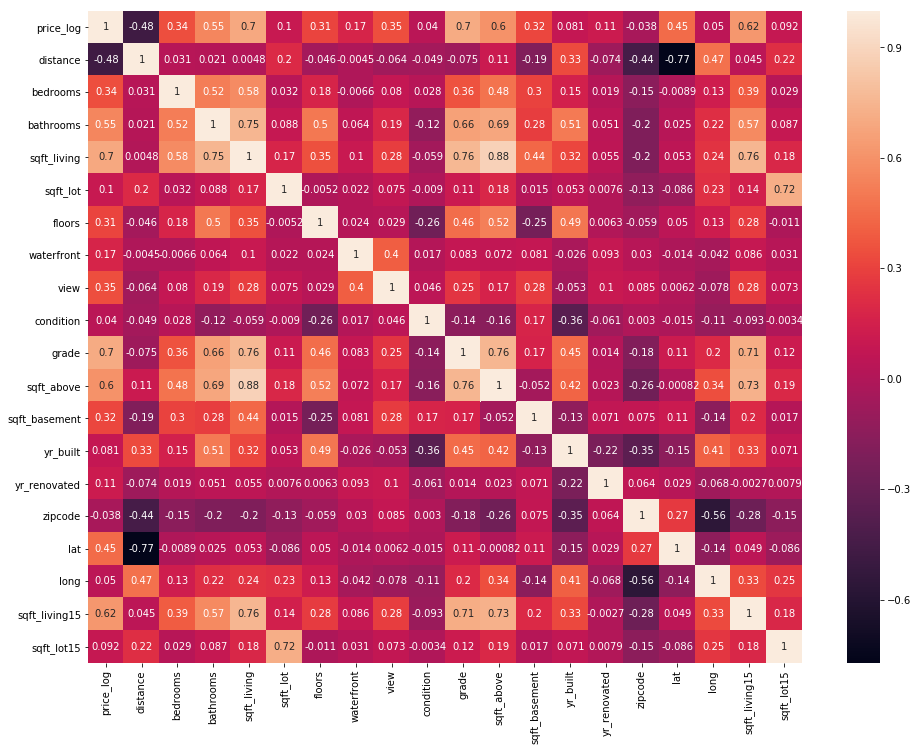

In [4]:
# コピーを作成
house_dt_temp = house_dt.copy()

#相関係数を算出
house_dt_corr = house_dt_temp.corr()

# ヒートマップ化
plt.figure(figsize=(16, 12))
sns.heatmap(house_dt_corr, annot=True)

# 訓練データとテストデータを作成

In [5]:
# 目的変数
target_col = "price_log"

# 特徴量として使うカラム名
feature_cols = [col for col in house_dt.columns.values if col != "price_log"]

X_ = house_dt[feature_cols] # 特徴量候補
y_ = house_dt[target_col] # 目的変数

In [6]:
# sklearnに投入するため、特徴量データを標準化した上で NumPyの配列化
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X_))
y = np.array(y_)

## 学習データとテストデータに分割

In [7]:
# クロスバリデーション用にテストデータを分割(学習：75% テスト:25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)

# AdaBoostを用いた予測モデルの構築

## AdaBoostのパラメータ 
- base_estimator=弱学習器に使用するモデル。デフォルト=DecisionTreeRegressor(max_depth=3)   
    アンサンブル学習の弱学習器として過学習をしやすい決定木をそのまま採用。
- learning_rate=アンサンブル時の間違った学習データに対する重みづけ。　デフォルト=1.0, 
- loss=重みづけを再計算する際のloss関数。デフォルト=linear 
- n_estimators=弱学習機の数、デフォルト=50, 
- random_state=None

In [8]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# AdaBoostをインスタンス化
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=1234)
# ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=10, random_state=1234) , random_state=1234)
# ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(max_depth=50, n_estimators=100, random_state=1234) , random_state=1234)

# X_train：特徴量のデータ、y_train：教師データ（価格）で学習
ada.fit(X_train, y_train)

# X_trainでモデルの検証し、価格を y_pred に格納
y_pred = ada.predict(X_test)

# 予測（y_pred2）と答え（y_train2）の誤差を計算
ada_mse = mean_squared_error(y_test, y_pred)

print("### AdaBoostRegressor detail: \n{}".format(ada))

print("### RMSE: {}".format(np.sqrt(ada_mse)))
print("### feature_importances_: \n{}".format(ada.feature_importances_))

print("### [train] coefficient of determination R^2: {:.2f}".format(ada.score(X_train, y_train)))
print("### [test] coefficient of determination R^2: {:.2f}".format(ada.score(X_test, y_test)))

### AdaBoostRegressor detail: 
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=1234)
### RMSE: 0.18009199474379495
### feature_importances_: 
[0.04597651 0.00267777 0.00558962 0.176877   0.01596236 0.00110223
 0.00650166 0.01403441 0.00589428 0.21493687 0.01841735 0.00294139
 0.02049616 0.00133444 0.00792111 0.38732814 0.02132513 0.03807593
 0.01260765]
### [train] coefficient of determination R^2: 0.98
### [test] coefficient of determination R^2: 0.88


# 変数選択

変数増加法で変数選択をしてみる  
変数増加法：一番説明力の高い特徴量(feature_importances_)から始めて、説明力の高い順番でRMSEを計算し、少なくなり続ける限り特徴量として採用していく。  

In [9]:
# 特徴量の重要度（feature_importances_）をDataFrame化
feature_importances = pd.DataFrame( ada.feature_importances_, index=columns_list[1:], columns=["feature_importances"])

# 重要度でソート
feature_importances = feature_importances.sort_values(by="feature_importances", ascending=False)
feature_importances

,feature_importances
lat,0.387328
grade,0.214937
sqft_living,0.176877
distance,0.045977
sqft_living15,0.038076
long,0.021325
yr_built,0.020496
sqft_above,0.018417
sqft_lot,0.015962
view,0.014034


In [10]:
# 変数増加法が行いやすいように重要度順に列名を入れ替え
X = X_.reindex(columns = feature_importances.index.values)

# 標準化
X  = scaler.fit_transform(X)

# sklearnに投入するため、NumPyの配列化
X = np.array(X)

In [11]:
def get_feature_names(X, y, feature_names, clf):
    """
    変数増加法による変数選択
    RMSEが小さくなる限り、特徴量として採用する。
    
    Args：
        X (numpy.ndarray): 列名を重要度順並べ替えた 特徴量データ
        y (numpy.ndarray): 教師データ
        feature_names(numpy.ndarray): 重要度順に並べた特徴量名
        clf : sklearnの学習モデル
    
    Returns:
        numpy.ndarray：採用した特徴量名の一覧
    """

    # 学習データを75%(X_train, y_train)、テストデータを30%(X_test, y_test)に分割にする。
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=1234)

    # 評価（MSE）を無限大で初期化
    last_rmse = np.inf

    #選ばれた特徴量の名前一覧
    chosen_features = []

    # 重要度順にAdaBoostを試す
    for i, col_name in enumerate(feature_names):

        chosen_features.append(col_name)
        size = len(chosen_features)

        # chosen_feature にある特徴量のみ使用して学習 (全行の len(chosen_features)目まで)
        clf.fit(X_train[:, :size], y_train)

        # 予測
        y_pred = clf.predict(X_test[:, :size])

        # RMSE（二乗平均平方根誤差 ）
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print("### Newly Added Feature: {},\tRMSE Score: {}".format(col_name, np.sqrt(rmse)))

        # 特徴量を増やす事で、RMSEが減らなくなったら終了
        if rmse >= last_rmse:
            break

        #直近のRMSEを更新
        last_rmse = rmse

    return chosen_features

In [12]:
# 各特徴量のRMSE（二乗平均平方根誤差）を出してみる
selected_feature_names = get_feature_names(
    X=X,
    y=y,
    feature_names=feature_importances.index.values,
    clf=AdaBoostRegressor(DecisionTreeRegressor(),
#         RandomForestRegressor(max_depth=50, n_estimators=100, random_state=1234),
        random_state=1234))

### Newly Added Feature: lat,	RMSE Score: 0.690269008322977
### Newly Added Feature: grade,	RMSE Score: 0.5679094452299228
### Newly Added Feature: sqft_living,	RMSE Score: 0.5029439580000461
### Newly Added Feature: distance,	RMSE Score: 0.4615840802042905
### Newly Added Feature: sqft_living15,	RMSE Score: 0.45304839823267934
### Newly Added Feature: long,	RMSE Score: 0.4390762985826739
### Newly Added Feature: yr_built,	RMSE Score: 0.438337999179201
### Newly Added Feature: sqft_above,	RMSE Score: 0.43747084046172957
### Newly Added Feature: sqft_lot,	RMSE Score: 0.432614220718525
### Newly Added Feature: view,	RMSE Score: 0.4300540116370113
### Newly Added Feature: sqft_lot15,	RMSE Score: 0.4282121180510123
### Newly Added Feature: zipcode,	RMSE Score: 0.4265508521635548
### Newly Added Feature: waterfront,	RMSE Score: 0.4264788726102121
### Newly Added Feature: condition,	RMSE Score: 0.4256723439649789
### Newly Added Feature: bathrooms,	RMSE Score: 0.4254953969290361
### Newly Ad

In [13]:
print(selected_feature_names)

['lat', 'grade', 'sqft_living', 'distance', 'sqft_living15', 'long', 'yr_built', 'sqft_above', 'sqft_lot', 'view', 'sqft_lot15', 'zipcode', 'waterfront', 'condition', 'bathrooms', 'sqft_basement', 'bedrooms']


### 変数選択後の精度を再確認

モデル選択時と同じデータを使用して再確認

In [14]:
size = len(selected_feature_names)

ada2 = AdaBoostRegressor(DecisionTreeRegressor(), random_state=1234)
# ada2 = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=10, random_state=1234) , random_state=1234)
# ada2 = AdaBoostRegressor(base_estimator=RandomForestRegressor(max_depth=50, n_estimators=100, random_state=1234) , random_state=1234)

ada2.fit(X_train[:, :size], y_train)  # 学習
y_pred2 = ada2.predict(X_test[:, :size])  # 予測

# MSE（平均２乗誤差）を計算
ada2_mse = mean_squared_error(y_test, y_pred2)

print("### RMSE: {}".format(np.sqrt(ada2_mse)))

print("### [train] coefficient of determination R^2: {:.2f}".format(ada2.score(X_train[:, :size], y_train)))
print("### [test] coefficient of determination R^2: {:.2f}".format(ada2.score(X_test[:, :size], y_test)))

### RMSE: 0.17851158763377584
### [train] coefficient of determination R^2: 0.98
### [test] coefficient of determination R^2: 0.88


RMSEは 0.18009199474379495 から下がったが、coefficient of determinationは変わらない。

# クロスバリデーションによるパラメーターのチューニング

AdaBoostのパラメータ
- base_estimator=弱学習機に使用するモデル。デフォルト=DecisionTreeRegressor(max_depth=3)
- learning_rate=アンサンブル時の間違った学習データに対する重みづけ。　デフォルト=1.0,
- loss=重みづけを再計算する際のloss関数。デフォルト=linear
- n_estimators=弱学習機の数、デフォルト=50,
- random_state=None

In [15]:
# from sklearn.tree import DecisionTreeRegressor

params = {
    "n_estimators": [25, 50, 75, 100],
    "learning_rate": [0.1, 0.25, 0.5, 0.75, 1.0]
    #     ,
    #     "base_estimator": [
    #         DecisionTreeRegressor(max_depth=3),
    #         DecisionTreeRegressor(max_depth=5),
    #         DecisionTreeRegressor(max_depth=10)
    #     ]
}

ハイパーパラメーターのチューニングをGridSearchで行う

In [16]:
gscv = GridSearchCV(ada2, param_grid=params, verbose=1, cv=3, scoring='neg_mean_squared_error')

In [17]:
# cv(クロスバリデーション)=3 で 4*5*3=60通り試す。
gscv.fit(X_train[:, :size], y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=1234),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [25, 50, 75, 100], 'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [18]:
gscv.best_params_

{'learning_rate': 0.5, 'n_estimators': 100}

#### パラメーターチューニング後のスコア

In [19]:
ada2 = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(),
#     base_estimator=RandomForestRegressor(
#         max_depth=50, n_estimators=100, random_state=1234),
    learning_rate=0.5,
    n_estimators=100,
    random_state=1234)

ada2.fit(X_train[:, :size], y_train)  # 学習
y_pred2 = ada2.predict(X_test[:, :size])  # 予測

# MSE（平均２乗誤差）を計算
ada2_mse = mean_squared_error(y_test, y_pred2)

print("### RMSE: {}".format(np.sqrt(ada2_mse)))

print("### [train] coefficient of determination R^2: {:.2f}".format(ada2.score(X_train[:, :size], y_train)))
print("### [test] coefficient of determination R^2: {:.2f}".format(ada2.score(X_test[:, :size], y_test)))

### RMSE: 0.17699095522734318
### [train] coefficient of determination R^2: 0.99
### [test] coefficient of determination R^2: 0.89


パラメータチューニング前より上がった
    ### RMSE: 0.17851158763377584
    ### [train] coefficient of determination R^2: 0.98
    ### [test] coefficient of determination R^2: 0.88

# 誤差を可視化

## 予測数値と実際の値の散布図

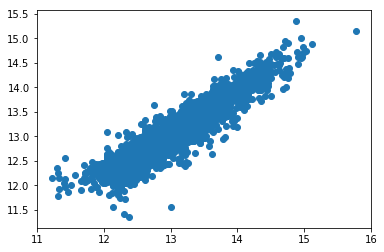

In [20]:
# 横軸が y_test_, 縦軸が y_pred_on_test
plt.scatter(y_test, y_pred2)

## 誤差のヒストグラム

Mean:  0.00014996600837349698
Std:  0.013726064747172978


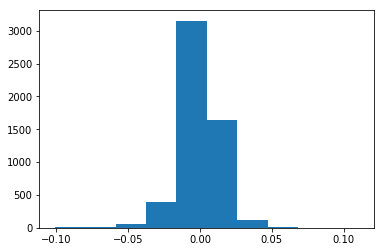

In [21]:
# 価格予測があっていれば、分子がゼロ
error_rate = (y_test - y_pred2) / y_test

# ヒストグラムを表示
plt.hist(error_rate)
print('Mean: ', np.mean(error_rate))
print('Std: ', np.std(error_rate))

Mean:  0.0002490816641552204  
Std:  0.014282495999386038

から値も小さくなっている。